In [184]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
from matplotlib import ticker
import matplotlib.dates as mdates
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category='SettingWithCopyWarning')
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import numpy as np

In [185]:
sys.path.append(os.getenv('DEV_HOME'))
sys.path.append(os.getenv('SITES_HOME'))

In [186]:
import covid_ont
from covid_ont import dataset_read, dataset_get, DIR_IMAGES, FIGSIZES

In [187]:
ontario_pop_estimate=14755211 # Q1 2021, source: https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000901

## Data

In [188]:
df=dataset_read('Vaccinations')
df.columns=['Date', 'Previous Day Doses Administered', 'Total Doses', 'Total Doses in Fully Vaccinated', 'Total Fully Vaccinated']
df.fillna(0, inplace=True)
df.set_index('Date', inplace=True)
df=df.astype(int)
df.index=pd.to_datetime(df.index)
df.insert(column='Percentage of Population Vaccinated with One Dose', loc=2, value=0)
df.insert(column='Percentage of Population Fully Vaccinated', loc=5, value=0)
df.tail()

Previous Day Doses Administered  Total Doses  \
Date                                                       
2021-05-02                            76685      5324369   
2021-05-03                            53880      5378249   
2021-05-04                            88871      5467120   
2021-05-05                           132603      5599723   
2021-05-06                           141038      5740761   

            Percentage of Population Vaccinated with One Dose  \
Date                                                            
2021-05-02                                                  0   
2021-05-03                                                  0   
2021-05-04                                                  0   
2021-05-05                                                  0   
2021-05-06                                                  0   

            Total Doses in Fully Vaccinated  Total Fully Vaccinated  \
Date                                                                  
2021-05-02                           750560                  375280   
2021-05-03                           751810                  375905   
2021-05-04                           756170                  378085   
2021-05-05                           762246                  381123   
2021-05-06                           769178                  384589   

            Percentage of Population Fully Vaccinated  
Date                                                   
2021-05-02                                          0  
2021-05-03                                          0  
2021-05-04                                          0  
2021-05-05                                          0  
2021-05-06                                          0

In [189]:
df.shape

(129, 6)

In [190]:
df['Percentage of Population Vaccinated with One Dose']= df['Total Doses'].apply(lambda x: x*100/ontario_pop_estimate)
df['Percentage of Population Fully Vaccinated'] = df['Total Fully Vaccinated'].apply(lambda x: x*100/ontario_pop_estimate)
df.tail()

Previous Day Doses Administered  Total Doses  \
Date                                                       
2021-05-02                            76685      5324369   
2021-05-03                            53880      5378249   
2021-05-04                            88871      5467120   
2021-05-05                           132603      5599723   
2021-05-06                           141038      5740761   

            Percentage of Population Vaccinated with One Dose  \
Date                                                            
2021-05-02                                          36.084669   
2021-05-03                                          36.449828   
2021-05-04                                          37.052130   
2021-05-05                                          37.950816   
2021-05-06                                          38.906668   

            Total Doses in Fully Vaccinated  Total Fully Vaccinated  \
Date                                                                  
2021-05-02                           750560                  375280   
2021-05-03                           751810                  375905   
2021-05-04                           756170                  378085   
2021-05-05                           762246                  381123   
2021-05-06                           769178                  384589   

            Percentage of Population Fully Vaccinated  
Date                                                   
2021-05-02                                   2.543373  
2021-05-03                                   2.547608  
2021-05-04                                   2.562383  
2021-05-05                                   2.582972  
2021-05-06                                   2.606462

<AxesSubplot:xlabel='Date'>

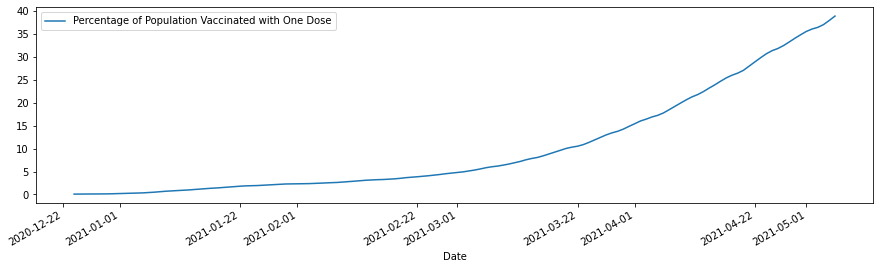

In [81]:
df[['Percentage of Population Vaccinated with One Dose']].plot(figsize=(15,4))

<AxesSubplot:xlabel='Date'>

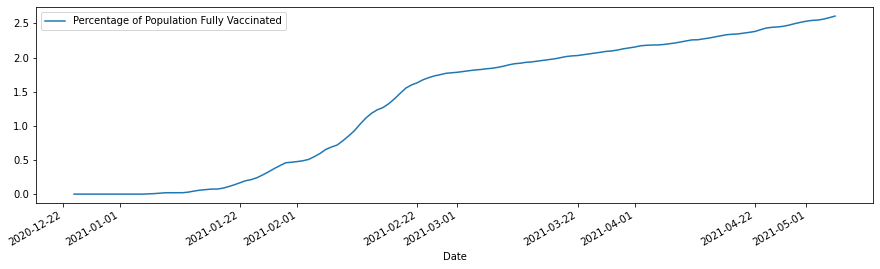

In [82]:
df[['Percentage of Population Fully Vaccinated']].plot(figsize=(15,4))

## Time Expanded 

In [85]:
df_future=df.append(pd.DataFrame([[0,0,0,0,0,0] for i in range(200)], index=pd.date_range(start=df.index.max(), periods=200, freq='D'), columns=df.columns))
df_future

Previous Day Doses Administered  Total Doses  \
2020-12-24                                0        10756   
2020-12-30                             4595        18603   
2020-12-31                             5463        23502   
2021-01-01                             5415        28887   
2021-01-02                             4305        33191   
...                                     ...          ...   
2021-11-17                                0            0   
2021-11-18                                0            0   
2021-11-19                                0            0   
2021-11-20                                0            0   
2021-11-21                                0            0   

            Percentage of Population Vaccinated with One Dose  \
2020-12-24                                           0.072896   
2020-12-30                                           0.126077   
2020-12-31                                           0.159279   
2021-01-01                                           0.195775   
2021-01-02                                           0.224944   
...                                                       ...   
2021-11-17                                           0.000000   
2021-11-18                                           0.000000   
2021-11-19                                           0.000000   
2021-11-20                                           0.000000   
2021-11-21                                           0.000000   

            Total Doses in Fully Vaccinated  Total Fully Vaccinated  \
2020-12-24                                0                       0   
2020-12-30                                0                       0   
2020-12-31                                0                       0   
2021-01-01                                0                       0   
2021-01-02                                0                       0   
...                                     ...                     ...   
2021-11-17                                0                       0   
2021-11-18                                0                       0   
2021-11-19                                0                       0   
2021-11-20                                0                       0   
2021-11-21                                0                       0   

            Percentage of Population Fully Vaccinated  
2020-12-24                                        0.0  
2020-12-30                                        0.0  
2020-12-31                                        0.0  
2021-01-01                                        0.0  
2021-01-02                                        0.0  
...                                               ...  
2021-11-17                                        0.0  
2021-11-18                                        0.0  
2021-11-19                                        0.0  
2021-11-20                                        0.0  
2021-11-21                                        0.0  

[329 rows x 6 columns]

<AxesSubplot:>

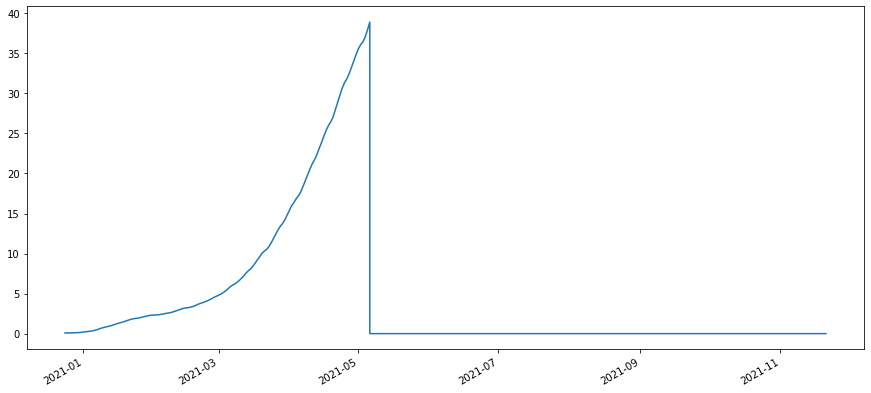

In [86]:
df_future['Percentage of Population Vaccinated with One Dose'].plot(figsize=(15,7))

## Model

In [87]:
X_act=np.reshape(df.index, (-1,1)) 
y_act=df['Percentage of Population Vaccinated with One Dose']

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_act, y_act, test_size=0.8, random_state=42)

In [89]:
pipe=make_pipeline(PolynomialFeatures(degree=6), Ridge())
pipe.fit(X_train, y_train).score(X_test, y_test)

0.9983500036624312

In [90]:
yhat=pipe.predict(X_act)

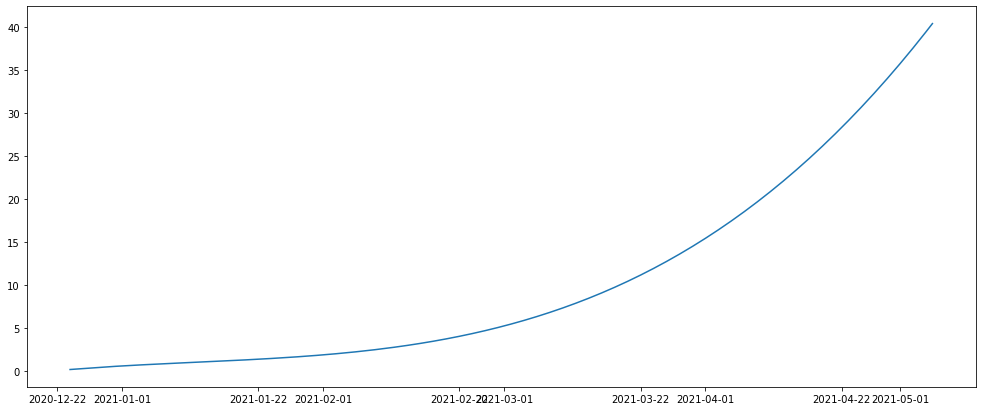

In [91]:
plt.figure(figsize=FIGSIZES)
plt.plot(df.index, yhat)

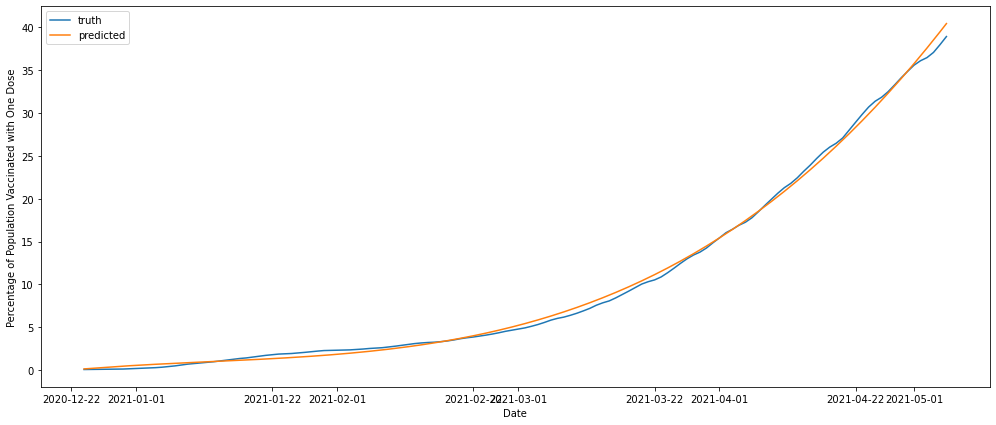

In [92]:
plt.figure(figsize=FIGSIZES)
sns.lineplot(x=df.index, y=y_act)
sns.lineplot(x=df.index, y=yhat)
plt.legend(['truth', 'predicted'])

## Prediction

In [180]:
df_pred=df_future.loc[df_future.index>df.index.max()][['Percentage of Population Vaccinated with One Dose']]
df_pred

Percentage of Population Vaccinated with One Dose
2021-05-07                                                0.0
2021-05-08                                                0.0
2021-05-09                                                0.0
2021-05-10                                                0.0
2021-05-11                                                0.0
...                                                       ...
2021-11-17                                                0.0
2021-11-18                                                0.0
2021-11-19                                                0.0
2021-11-20                                                0.0
2021-11-21                                                0.0

[199 rows x 1 columns]

In [181]:
X_pred=np.reshape(df_pred.index, (-1,1))
y_pred=pipe.predict(X_pred)

In [182]:
df_pred['Percentage of Population Vaccinated with One Dose']=y_pred
df_pred=df_pred[df_pred['Percentage of Population Vaccinated with One Dose']<100]
df_plot_pred=df_pred.copy()
df_plot_pred.columns=['Projection']

In [192]:
df_plot_act=df.copy()[['Percentage of Population Vaccinated with One Dose']]
df_plot_act.columns=['Actual']

<AxesSubplot:title={'center':'Percentage of Population Vaccinated with One Dose'}, xlabel='Date'>

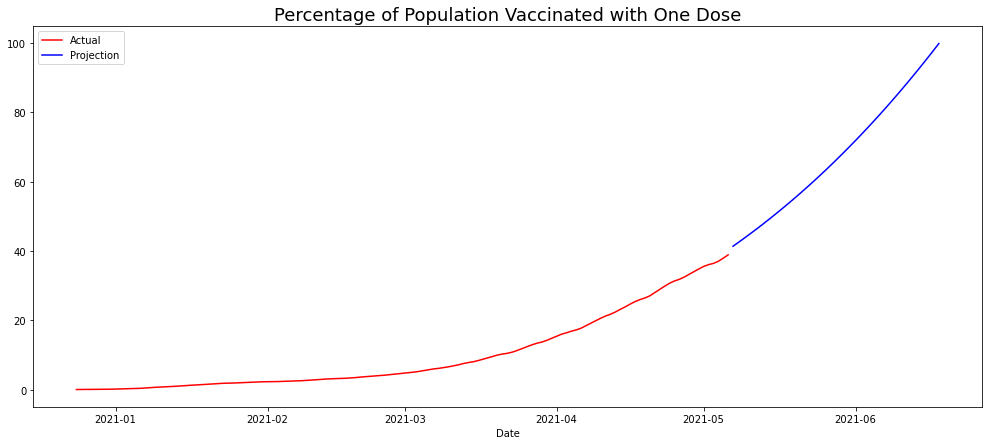

In [195]:
labels=['Actual', 'Projection']
plt.figure(figsize=FIGSIZES)
plt.title('Percentage of Population Vaccinated with One Dose', fontsize=18)
sns.lineplot(data=df_plot_act, palette=['red'])
sns.lineplot(data=df_plot_pred, palette=['blue'])